## <u>Introduction</u>

The dataframe consists of <b>162421</b> complaints for <b>5 products</b>. The dataframe is considerably <b>imbalanced</b>. 

The notebook implements <b>Bi-LSTM</b> model for <b>multiclass</b> classification of product complaints. Based on the provided <b>complaints</b>, the goal of the notebook is to accurately <b>identify the product</b>.    

# Libraries

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# 1. Reading and Analysing DataFrame

In [2]:
# Reading dataframe
df = pd.read_csv('complaints_processed.csv')
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [3]:
# Renaming columns 
df = df.rename(columns={'narrative':'tweet' })

# Removing SNo column
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,product,tweet
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [4]:
# Analysing dataframe attributes 
print('* Size of dataframe: {}\n'.format(df.shape))
print('* Datatype of columns are:\n {}\n'.format(df.dtypes))
print('* Count of different product categories:\n {}\n'.format(df['product'].value_counts()))
print('* Number of NaNs among tweets are: {}\n'.format(df['tweet'].isnull().sum())) 

* Size of dataframe: (162421, 2)

* Datatype of columns are:
 product    object
tweet      object
dtype: object

* Count of different product categories:
 product
credit_reporting       91179
debt_collection        23150
mortgages_and_loans    18990
credit_card            15566
retail_banking         13536
Name: count, dtype: int64

* Number of NaNs among tweets are: 10



In [5]:
# Removing NaNs
df = df.dropna(subset=['tweet'])
print('NaNs are removed from the dataframe. Number of NaNs can be confirmed to be {}. The size of dataframe has reduced to {}'.format(df['tweet'].isnull().sum(), df.shape))

NaNs are removed from the dataframe. Number of NaNs can be confirmed to be 0. The size of dataframe has reduced to (162411, 2)


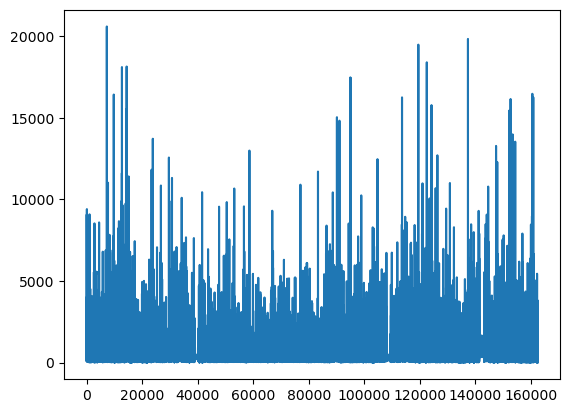

In [6]:
# Plotting word lenghts of tweets
word_length = [len(x) for x in df['tweet']]
plt.plot(word_length)

In [7]:
# Converting sentences to string
df['tweet'] = df['tweet'].astype(str)

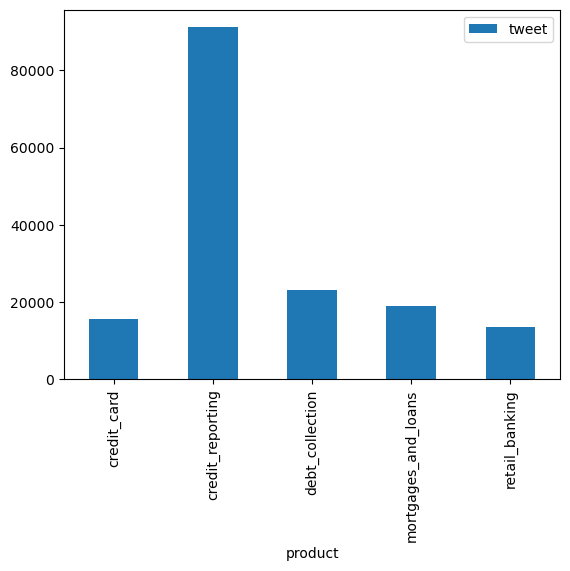

In [8]:
# Plotting product value counts
df.groupby('product').count().plot(kind='bar')
plt.show()

Dataframe is <b>imbalanced</b>. Improving the balance of the dataframe can improve <b>accuracy</b>.

# 3. Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [9]:
sent_10 = df['tweet'].values[10]
print(sent_10)
print("="*50)

sent_1000 = df['tweet'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = df['tweet'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = df['tweet'].values[4900]
print(sent_4900)
print("="*50)

beginning mortgage held mb financial mb mortgage portfolio purchased bank first quarter mb financial customer began fall behind mortgage payment due unemployment divorce house went foreclosure later sheriff sale home scheduled morning submitted hardship application end documentation specific date letter dated acknowledges application discussed next step never received written verbal confirmation regarding status hardship application day scheduled sheriff sale communication way sale never provided clear determination application made payment brought account current able taking loan group friend would lost home sheriff auction day sale received express mail letter dated date scheduled sheriff sale saying hardship application approved detail trial payment plan received letter timeframe required promised would take full loan friend would made required payment delay review option held numerous call since large payment told trial plan leading loan modification place payment plan fact made br

In [10]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "I would",
"i'd've": "I would have",
"i'll": "I will",
"i'll've": "I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that has",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there has",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they shall",
"they'll've": "they shall have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall",
"what'll've": "what shall have",
"what're": "what are",
"what's": "what has",
"what've": "what have",
"when's": "when has",
"when've": "when have",
"where'd": "where did",
"where's": "where has",
"where've": "where have",
"who'll": "who shall",
"who'll've": "who shall have",
"who's": "who has",
"who've": "who have",
"why's": "why has",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you shall",
"you'll've": "you shall have",
"you're": "you are",
"you've": "you have"
}

from nltk.tokenize import word_tokenize
def full_word(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    return text

df['tweet'] = df['tweet'].apply(full_word)

In [11]:
from bs4 import BeautifulSoup

#removing HTML tags
def remove_http(text):
    return re.sub(r"http\S+", "", text).strip()

#Remove puncuation
def remove_punc(text):
    return re.sub('[^A-Za-z0-9]+', ' ',text).strip()

#Remove no or alphanumeric words
def remove_numbers(text):
    return re.sub(r'\S*\d\S*', '', text).strip()

#Convert to lowercase

def lowercase(text):
    lower = None
    if text is None:
        return ""  
    return text.lower()


# Apply the function to the DataFrame column
df['tweet'] = df['tweet'].apply(remove_http)
df['tweet'] = df['tweet'].apply(remove_punc)
df['tweet'] = df['tweet'].apply(remove_numbers)
df['tweet'] = df['tweet'].apply(lowercase)


In [12]:
sent_10 = df['tweet'].values[10]
print(sent_10)
print("="*50)

sent_1000 = df['tweet'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = df['tweet'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = df['tweet'].values[4900]
print(sent_4900)
print("="*50)

beginning mortgage held mb financial mb mortgage portfolio purchased bank first quarter mb financial customer began fall behind mortgage payment due unemployment divorce house went foreclosure later sheriff sale home scheduled morning submitted hardship application end documentation specific date letter dated acknowledges application discussed next step never received written verbal confirmation regarding status hardship application day scheduled sheriff sale communication way sale never provided clear determination application made payment brought account current able taking loan group friend would lost home sheriff auction day sale received express mail letter dated date scheduled sheriff sale saying hardship application approved detail trial payment plan received letter timeframe required promised would take full loan friend would made required payment delay review option held numerous call since large payment told trial plan leading loan modification place payment plan fact made br

In [13]:
stop_words= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


def remove_stop_words(text):
   
    words = word_tokenize(text)
    
    filtered_words = [word for word in words if word.lower() not in stop_words]
   
    return ' '.join(filtered_words)

df['tweet'] = df['tweet'].apply(remove_stop_words)

In [14]:
sent_10 = df['tweet'].values[10]
print(sent_10)
print("="*50)

sent_1000 = df['tweet'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = df['tweet'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = df['tweet'].values[4900]
print(sent_4900)
print("="*50)

beginning mortgage held mb financial mb mortgage portfolio purchased bank first quarter mb financial customer began fall behind mortgage payment due unemployment divorce house went foreclosure later sheriff sale home scheduled morning submitted hardship application end documentation specific date letter dated acknowledges application discussed next step never received written verbal confirmation regarding status hardship application day scheduled sheriff sale communication way sale never provided clear determination application made payment brought account current able taking loan group friend would lost home sheriff auction day sale received express mail letter dated date scheduled sheriff sale saying hardship application approved detail trial payment plan received letter timeframe required promised would take full loan friend would made required payment delay review option held numerous call since large payment told trial plan leading loan modification place payment plan fact made br

# 3. Data Preparation - Class imbalance

In [15]:
import pandas as pd
from sklearn.utils import resample

def undersample_text_data(X, y):
    """
    Perform undersampling to balance class distribution in a dataset.
    
    Parameters:
    - X (pd.Series or pd.DataFrame): Text data.
    - y (pd.Series): Labels or target values.
    
    Returns:
    - X_resampled (pd.Series or pd.DataFrame): Resampled text data.
    - y_resampled (pd.Series): Resampled labels.
    """
    # Combine text data and labels into a single DataFrame
    data = pd.DataFrame({'text': X, 'label': y})
    
    # Identify the minimum class size
    min_class_size = data['label'].value_counts().min()
    
    # List to hold resampled data
    resampled_data = []
    
    # Perform undersampling for each class
    for label in data['label'].unique():
        class_data = data[data['label'] == label]
        class_data_resampled = resample(class_data, replace=False, n_samples=min_class_size, random_state=42)
        resampled_data.append(class_data_resampled)
    
    # Combine resampled data
    resampled_data = pd.concat(resampled_data)
    
    # Split the resampled data back into X and y
    X_resampled = resampled_data['text']
    y_resampled = resampled_data['label']
    
    return X_resampled, y_resampled


In [16]:
df['product'].unique()

array(['credit_card', 'retail_banking', 'credit_reporting',
       'mortgages_and_loans', 'debt_collection'], dtype=object)

In [17]:
product_mapping = {name: idx for idx, name in enumerate(df['product'].unique())}

# Map the 'product' column to integers using the mapping
df['product'] = df['product'].map(product_mapping)

In [18]:
print(product_mapping)

{'credit_card': 0, 'retail_banking': 1, 'credit_reporting': 2, 'mortgages_and_loans': 3, 'debt_collection': 4}


In [19]:
X_resampled, y_resampled = undersample_text_data(df['tweet'], df['product']) 

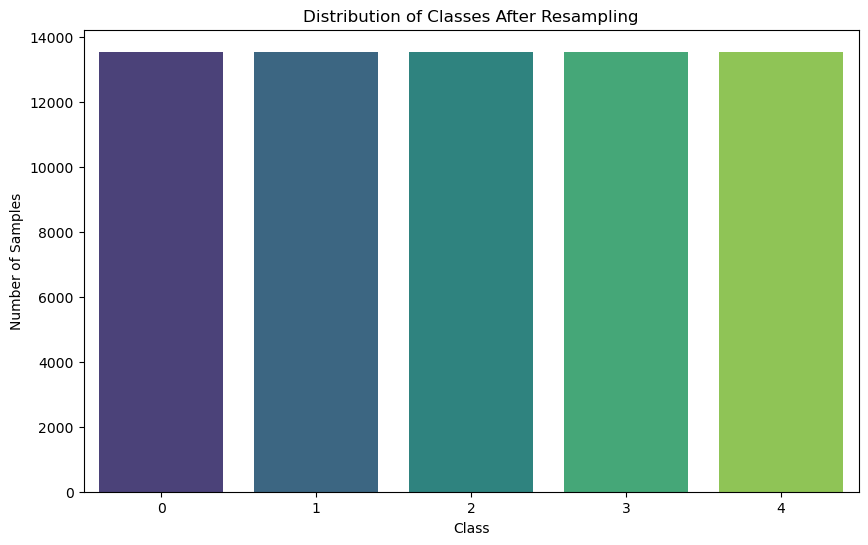

In [20]:
df_resampled = pd.DataFrame({'Class': y_resampled})

class_counts = df_resampled['Class'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes After Resampling')
plt.show()

In [21]:
y_resampled_df = pd.DataFrame({'label': y_resampled})
y_one_hot = pd.get_dummies(y_resampled_df['label'])

y_final = y_one_hot.to_numpy()

# 4. Featurization

## 4.1 BAG OF WORDS

In [25]:
preprocessed_reviews=X_resampled.copy()

In [26]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names_out()[:50])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa' 'aaa' 'aaadvantage' 'aab' 'aaccount' 'aacount' 'aadvant'
 'aadvantage' 'aadvantages' 'aadvatage' 'aafees' 'aafes' 'aag' 'aaid'
 'aams' 'aan' 'aand' 'aany' 'aappeared' 'aapply' 'aaragon' 'aargon'
 'aaron' 'aarp' 'aasessed' 'aasociated' 'ab' 'aba' 'aback' 'abad'
 'abandon' 'abandonded' 'abandoned' 'abandoning' 'abandonment'
 'abandonned' 'abartration' 'abate' 'abated' 'abatement' 'abbott'
 'abbreviate' 'abbreviated' 'abbreviation' 'abc' 'abck' 'abd' 'abdicated'
 'abdicating' 'abdication']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (67675, 36943)
the number of unique words  36943


## 4.2 Bi-Grams and n-Grams.

In [27]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (67675, 88357)
the number of unique words including both unigrams and bigrams  88357


## 4.3 TF-IDF

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names_out()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa' 'aadvantage' 'aadvantage card' 'aafes' 'aargon' 'aargon agency'
 'aargon collection' 'ab' 'ab inito' 'abandoned']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (67675, 88357)
the number of unique words including both unigrams and bigrams  88357


## 4.4 Word2Vec

### 4.4.1 Avg W2v

In [30]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from scipy.sparse import csr_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed


# Load the pre-trained word2vec model
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [31]:
# Function to compute the average word2vec vector of a given review
def average_w2v_vector(review, model):
    words = review.split()  # Simple tokenization; consider using a tokenizer for better results
    word_vectors = [model[word] for word in words if word in model]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [32]:
def process_reviews_with_index(index_reviews, model):
    indices, reviews = zip(*index_reviews)  # Unzip indices and reviews
    vectors = [average_w2v_vector(review, model) for review in reviews]
    return indices, np.array(vectors)

# Parameters for parallel processing
num_workers = 8 

# Split DataFrame into chunks for parallel processing while keeping index
def split_dataframe_with_index(df, num_chunks):
    indices = df.index.tolist()
    reviews = df.tolist()
    chunks = np.array_split(list(zip(indices, reviews)), num_chunks)
    return chunks

In [33]:
# Using ThreadPoolExecutor for parallel processing
chunks = split_dataframe_with_index(preprocessed_reviews, num_workers)
results = []

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [executor.submit(process_reviews_with_index, chunk, model) for chunk in chunks]
    for future in as_completed(futures):
        indices, vectors = future.result()
        results.extend(zip(indices, vectors))

# Sort results by index and combine vectors
results.sort(key=lambda x: x[0])
indices, vectors = zip(*results)

# Convert the array to a scipy sparse matrix
vectors = np.array(vectors)
Avg_w2v_matrix = csr_matrix(vectors)

print("the type of count vectorizer ",type(Avg_w2v_matrix))
print("the shape of out text Avg. W2V vectorizer ",Avg_w2v_matrix.get_shape())
print("the number of unique words including Avg. W2V", Avg_w2v_matrix.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text Avg. W2V vectorizer  (67675, 300)
the number of unique words including Avg. W2V 300


In [34]:
del(results)
del(vectors)
del(chunks)

# 5. Training & Evaluation

## 5.1 Logistic Regression

In [35]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix
import numpy as np

def evaluate_classification_model(X, y, dataset_size=1.0):
    """
    Evaluate a multi-class classification model on vectorized text data using one-vs-rest classification and L1 regularization with 10-fold cross-validation.
    
    Parameters:
    - X: scipy.sparse.csr_matrix
        The feature matrix with vectorized text data in CSR format.
    - y: np.ndarray
        The true class labels in one-hot encoded format (binary matrix).
    - dataset_size: float
        The proportion of the dataset to use (between 0 and 1). Default is 1.0 (use the whole dataset).

    Returns:
    - mean_accuracy: float
        The mean accuracy of the model across all folds.
    - mean_conf_matrix: np.ndarray
        The mean confusion matrix of the model across all folds.
    - avg_classification_report: str
        The average classification report of the model across all folds.
    """
    
    # Check that X is a CSR matrix
    if not isinstance(X, csr_matrix):
        raise TypeError("X should be a scipy.sparse.csr_matrix")

    # Validate dataset_size
    if not (0 < dataset_size <= 1):
        raise ValueError("dataset_size must be between 0 and 1")

    # Optionally select a subset of the data
    if dataset_size < 1.0:
        # Determine the number of samples to use
        num_samples = int(X.shape[0] * dataset_size)
        indices = np.random.choice(X.shape[0], num_samples, replace=False)
        X = X[indices]
        y = y[indices]

    # Convert one-hot encoded labels to class labels
    y_labels = np.argmax(y, axis=1)
    
    # Define the model with L1 regularization and parallel processing
    model = LogisticRegression(
        penalty='l1', 
        solver='saga', 
        max_iter=1000, 
        multi_class='ovr',
        random_state=42,
        n_jobs=-1  # Use all available cores for parallel processing
    )
    
    # Define cross-validation strategy
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    accuracies = []
    conf_matrices = []
    reports = []

    for train_index, test_index in skf.split(X, y_labels):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_labels[train_index], y_labels[test_index]
        
        # Fit the model on the training data
        model.fit(X_train, y_train)
        
        # Predict on the test data
        y_pred_labels = model.predict(X_test)
        
        # Convert predictions to one-hot encoding
        y_pred = np.zeros((y_pred_labels.size, y_pred_labels.max() + 1))
        y_pred[np.arange(y_pred_labels.size), y_pred_labels] = 1

        # Convert y_test to one-hot encoding
        y_test_onehot = np.zeros((y_test.size, y_test.max() + 1))
        y_test_onehot[np.arange(y_test.size), y_test] = 1

        # Compute accuracy and confusion matrix
        accuracy = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(y_pred, axis=1))
        conf_matrix = confusion_matrix(np.argmax(y_test_onehot, axis=1), np.argmax(y_pred, axis=1))

        # Compute classification report
        report = classification_report(np.argmax(y_test_onehot, axis=1), np.argmax(y_pred, axis=1), output_dict=True)
        reports.append(report)

        accuracies.append(accuracy)
        conf_matrices.append(conf_matrix)

    # Calculate mean accuracy and mean confusion matrix
    mean_accuracy = np.mean(accuracies)
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    
    # Compute average classification report
    avg_report = {}
    all_labels = list(reports[0].keys())
    for label in all_labels:
        if label == 'accuracy':
            avg_report[label] = np.mean([report[label] for report in reports])
        else:
            avg_report[label] = {}
            avg_report[label]['precision'] = np.mean([report[label]['precision'] for report in reports])
            avg_report[label]['recall'] = np.mean([report[label]['recall'] for report in reports])
            avg_report[label]['f1-score'] = np.mean([report[label]['f1-score'] for report in reports])
            avg_report[label]['support'] = np.mean([report[label]['support'] for report in reports])
    
    avg_classification_report = classification_report(y_labels, model.predict(X), output_dict=True)

    return mean_accuracy, mean_conf_matrix, avg_report

### 5.1.1 BOW

In [36]:
# Evaluate with hyperparameter tuning
accuracy_BOW, conf_matrix_BOW,report_BOW = evaluate_classification_model(final_counts,y_final,0.1)
print("Accuracy (Tuning):", accuracy_BOW)
print("Confusion Matrix (Tuning):\n", conf_matrix_BOW)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy (Tuning): 0.8012417244578636
Confusion Matrix (Tuning):
 [[358.          46.33333333  22.66666667  12.          15.66666667]
 [ 45.33333333 362.66666667   4.33333333   9.66666667   8.33333333]
 [ 21.66666667   5.33333333 381.          23.33333333  42.        ]
 [ 15.66666667  19.33333333  20.33333333 378.33333333  19.66666667]
 [ 21.33333333   9.          62.          24.33333333 327.33333333]]


## 5.1.2 Bi-Grams & n-Grams

In [37]:
accuracy_BIGram, conf_matrix_BIGram,report_BIGram = evaluate_classification_model(final_bigram_counts, y_final,0.1)
print("Accuracy (Tuning):", accuracy_BIGram)
print("Confusion Matrix (Tuning):\n", conf_matrix_BIGram)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy (Tuning): 0.8143938083481416
Confusion Matrix (Tuning):
 [[347.66666667  52.66666667  24.66666667  11.          16.66666667]
 [ 39.66666667 385.66666667   3.66666667   8.33333333   4.66666667]
 [ 21.           3.66666667 381.66666667  22.33333333  37.33333333]
 [ 16.33333333  13.33333333  21.66666667 385.66666667  15.66666667]
 [ 15.33333333  10.66666667  55.33333333  24.66666667 336.33333333]]


## 5.1.3 TF-IDF

In [38]:
accuracy_IFIDF, conf_matrix_TFIDF,report_TFIDF = evaluate_classification_model(final_tf_idf, y_final,0.1)
print("Accuracy (Tuning):", accuracy_IFIDF)
print("Confusion Matrix (Tuning):\n", conf_matrix_TFIDF)

Accuracy (Tuning): 0.8050830044083807
Confusion Matrix (Tuning):
 [[346.33333333  49.33333333  24.          16.          10.33333333]
 [ 35.66666667 388.           6.33333333  12.           2.33333333]
 [ 21.           7.         359.66666667  33.66666667  39.66666667]
 [ 12.33333333  17.33333333  19.         382.          13.        ]
 [ 18.          16.33333333  60.66666667  25.66666667 340.        ]]


## 5.1.4 Avg-Word2Vec

In [39]:
accuracy_AVG_w2v, conf_matrix_AVG_w2v,report_w2v = evaluate_classification_model(Avg_w2v_matrix, y_final,0.1)
print("Accuracy (Tuning):", accuracy_AVG_w2v)
print("Confusion Matrix (Tuning):\n", conf_matrix_AVG_w2v)

Accuracy (Tuning): 0.28801507550858874
Confusion Matrix (Tuning):
 [[173.66666667  79.          49.66666667  84.66666667  56.66666667]
 [ 99.33333333 164.33333333  71.          78.33333333  53.33333333]
 [106.33333333 121.33333333  98.66666667  81.33333333  51.66666667]
 [113.66666667  90.66666667  57.66666667 138.33333333  53.33333333]
 [113.          85.          69.66666667  90.33333333  74.66666667]]


## 5.2 SVM

In [40]:
from sklearn.svm import SVC

def evaluate_classification_model_SVM(X, y, dataset_size=1.0):
    """
    Evaluate a multi-class classification model on vectorized text data using one-vs-rest classification and SVM with RBF kernel with 10-fold cross-validation.
    
    Parameters:
    - X: scipy.sparse.csr_matrix
        The feature matrix with vectorized text data in CSR format.
    - y: np.ndarray
        The true class labels in one-hot encoded format (binary matrix).
    - dataset_size: float
        The proportion of the dataset to use (between 0 and 1). Default is 1.0 (use the whole dataset).

    Returns:
    - mean_accuracy: float
        The mean accuracy of the model across all folds.
    - mean_conf_matrix: np.ndarray
        The mean confusion matrix of the model across all folds.
    """
    
    # Check that X is a CSR matrix
    if not isinstance(X, csr_matrix):
        raise TypeError("X should be a scipy.sparse.csr_matrix")

    # Validate dataset_size
    if not (0 < dataset_size <= 1):
        raise ValueError("dataset_size must be between 0 and 1")

    # Optionally select a subset of the data
    if dataset_size < 1.0:
        # Determine the number of samples to use
        num_samples = int(X.shape[0] * dataset_size)
        indices = np.random.choice(X.shape[0], num_samples, replace=False)
        X = X[indices]
        y = y[indices]

    # Convert one-hot encoded labels to class labels
    y_labels = np.argmax(y, axis=1)
    
    # Define the model with RBF kernel and parallel processing
    model = SVC(
        kernel='rbf', 
        C=1.0,          # Regularization parameter
        gamma='scale',  # Kernel coefficient
        decision_function_shape='ovr',
        random_state=42
    )
    
    # Define cross-validation strategy
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    accuracies = []
    conf_matrices = []
    reports = []
    
    for train_index, test_index in skf.split(X, y_labels):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_labels[train_index], y_labels[test_index]
        
        # Fit the model on the training data
        model.fit(X_train, y_train)
        
        # Predict on the test data
        y_pred_labels = model.predict(X_test)
        
        # Convert predictions to one-hot encoding
        y_pred = np.zeros((y_pred_labels.size, y_pred_labels.max() + 1))
        y_pred[np.arange(y_pred_labels.size), y_pred_labels] = 1

        # Convert y_test to one-hot encoding
        y_test_onehot = np.zeros((y_test.size, y_test.max() + 1))
        y_test_onehot[np.arange(y_test.size), y_test] = 1

        # Compute accuracy and confusion matrix
        accuracy = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(y_pred, axis=1))
        conf_matrix = confusion_matrix(np.argmax(y_test_onehot, axis=1), np.argmax(y_pred, axis=1))
        report = classification_report(np.argmax(y_test_onehot, axis=1), np.argmax(y_pred, axis=1), output_dict=True)

        accuracies.append(accuracy)
        conf_matrices.append(conf_matrix)
        reports.append(report)

    # Calculate mean accuracy and mean confusion matrix
    mean_accuracy = np.mean(accuracies)
    mean_conf_matrix = np.mean(conf_matrices, axis=0)

    avg_report = {}
    all_labels = list(reports[0].keys())
    for label in all_labels:
        if label == 'accuracy':
            avg_report[label] = np.mean([report[label] for report in reports])
        else:
            avg_report[label] = {}
            avg_report[label]['precision'] = np.mean([report[label]['precision'] for report in reports])
            avg_report[label]['recall'] = np.mean([report[label]['recall'] for report in reports])
            avg_report[label]['f1-score'] = np.mean([report[label]['f1-score'] for report in reports])
            avg_report[label]['support'] = np.mean([report[label]['support'] for report in reports])
    
    avg_classification_report = classification_report(y_labels, model.predict(X), output_dict=True)

    return mean_accuracy, mean_conf_matrix, avg_report

### 5.2.1 BOW

In [41]:
# Evaluate with hyperparameter tuning
accuracy_BOW_SVM, conf_matrix_BOW_SVM,report_BOW_SVM = evaluate_classification_model_SVM(final_counts,y_final,0.1)
print("Accuracy (Tuning):", accuracy_BOW_SVM)
print("Confusion Matrix (Tuning):\n", conf_matrix_BOW_SVM)

Accuracy (Tuning): 0.7846899194330433
Confusion Matrix (Tuning):
 [[345.          52.33333333  25.          29.          15.        ]
 [ 29.         384.33333333   7.66666667  24.33333333   2.33333333]
 [ 15.66666667   5.66666667 353.66666667  34.          30.66666667]
 [ 12.          21.33333333  28.66666667 380.66666667  14.66666667]
 [ 17.          15.          75.66666667  30.66666667 306.33333333]]


### 5.2.2 Bi-Grams and n-Grams

In [42]:
accuracy_BIGram_SVM, conf_matrix_BIGram_SVM,report_BIGram_SVM = evaluate_classification_model_SVM(final_bigram_counts, y_final,0.1)
print("Accuracy (Tuning):", accuracy_BIGram_SVM)
print("Confusion Matrix (Tuning):\n", conf_matrix_BIGram_SVM)

Accuracy (Tuning): 0.7818812803698636
Confusion Matrix (Tuning):
 [[341.          56.66666667  27.          26.66666667  11.66666667]
 [ 32.33333333 388.66666667   5.          19.           4.33333333]
 [ 22.33333333   7.66666667 373.33333333  33.66666667  28.66666667]
 [ 14.66666667  22.66666667  29.66666667 350.          11.66666667]
 [ 20.66666667  15.33333333  69.33333333  33.         310.66666667]]


### 5.2.3 TF-IDF

In [43]:
accuracy_IFIDF_SVM, conf_matrix_TFIDF_SVM,report_IFIDF_SVM = evaluate_classification_model_SVM(final_tf_idf, y_final,0.1)
print("Accuracy (Tuning):", accuracy_IFIDF_SVM)
print("Confusion Matrix (Tuning):\n", conf_matrix_TFIDF_SVM)

Accuracy (Tuning): 0.8303526966604289
Confusion Matrix (Tuning):
 [[345.66666667  40.          19.66666667  14.66666667  11.66666667]
 [ 38.33333333 416.33333333   3.           7.33333333   4.33333333]
 [ 16.66666667   3.         361.66666667  30.33333333  34.33333333]
 [  9.33333333  18.66666667  13.33333333 410.33333333  15.66666667]
 [ 20.66666667   5.33333333  52.          24.33333333 339.        ]]


### 5.2.4 Avg Word2Vec

In [44]:
accuracy_AVG_w2v_SVM, conf_matrix_AVG_w2v_SVM,report_w2v_SVM = evaluate_classification_model_SVM(Avg_w2v_matrix, y_final,0.1)
print("Accuracy (Tuning):", accuracy_AVG_w2v_SVM)
print("Confusion Matrix (Tuning):\n", conf_matrix_AVG_w2v_SVM)

Accuracy (Tuning): 0.30752104595514046
Confusion Matrix (Tuning):
 [[183.66666667  67.33333333  32.          75.66666667  95.33333333]
 [106.33333333 128.          55.          66.33333333  99.33333333]
 [ 90.33333333  79.66666667  83.66666667  72.          92.        ]
 [119.33333333  51.66666667  43.         136.          98.        ]
 [123.          69.33333333  46.          80.33333333 162.33333333]]


## 5.3 Naive Bayes

In [49]:
from sklearn.naive_bayes import MultinomialNB

def evaluate_classification_model_NB(X, y, dataset_size=1.0):
    """
    Evaluate a multi-class classification model on vectorized text data using Naive Bayes classifier with 10-fold cross-validation.
    
    Parameters:
    - X: scipy.sparse.csr_matrix
        The feature matrix with vectorized text data in CSR format.
    - y: np.ndarray
        The true class labels in one-hot encoded format (binary matrix).
    - dataset_size: float
        The proportion of the dataset to use (between 0 and 1). Default is 1.0 (use the whole dataset).

    Returns:
    - mean_accuracy: float
        The mean accuracy of the model across all folds.
    - mean_conf_matrix: np.ndarray
        The mean confusion matrix of the model across all folds.
    """
    
    # Check that X is a CSR matrix
    if not isinstance(X, csr_matrix):
        raise TypeError("X should be a scipy.sparse.csr_matrix")

    # Validate dataset_size
    if not (0 < dataset_size <= 1):
        raise ValueError("dataset_size must be between 0 and 1")

    # Optionally select a subset of the data
    if dataset_size < 1.0:
        # Determine the number of samples to use
        num_samples = int(X.shape[0] * dataset_size)
        indices = np.random.choice(X.shape[0], num_samples, replace=False)
        X = X[indices]
        y = y[indices]

    # Convert one-hot encoded labels to class labels
    y_labels = np.argmax(y, axis=1)
    
    # Define the model for Naive Bayes
    model = MultinomialNB()
    
    # Define cross-validation strategy
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    accuracies = []
    conf_matrices = []
    reports = []
    
    for train_index, test_index in skf.split(X, y_labels):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_labels[train_index], y_labels[test_index]
        
        # Fit the model on the training data
        model.fit(X_train, y_train)
        
        # Predict on the test data
        y_pred_labels = model.predict(X_test)
        
        # Compute accuracy and confusion matrix
        accuracy = accuracy_score(y_test, y_pred_labels)
        conf_matrix = confusion_matrix(y_test, y_pred_labels)
        report = classification_report(y_test, y_pred_labels, output_dict=True)
        
        reports.append(report)
        accuracies.append(accuracy)
        conf_matrices.append(conf_matrix)

    # Calculate mean accuracy and mean confusion matrix
    mean_accuracy = np.mean(accuracies)
    mean_conf_matrix = np.mean(conf_matrices, axis=0)

    # Compute average classification report
    avg_report = {}
    all_labels = list(reports[0].keys())
    for label in all_labels:
        if label == 'accuracy':
            avg_report[label] = np.mean([report[label] for report in reports])
        else:
            avg_report[label] = {}
            avg_report[label]['precision'] = np.mean([report[label]['precision'] for report in reports])
            avg_report[label]['recall'] = np.mean([report[label]['recall'] for report in reports])
            avg_report[label]['f1-score'] = np.mean([report[label]['f1-score'] for report in reports])
            avg_report[label]['support'] = np.mean([report[label]['support'] for report in reports])
    
    avg_classification_report = classification_report(y_labels, model.predict(X), output_dict=True)

    return mean_accuracy, mean_conf_matrix, avg_report


### 5.3.1 BOW

In [50]:
# Evaluate with hyperparameter tuning
accuracy_BOW_NB, conf_matrix_BOW_NB,report_BOW_NB = evaluate_classification_model_NB(final_counts,y_final,0.1)
print("Accuracy (Tuning):", accuracy_BOW_NB)
print("Confusion Matrix (Tuning):\n", conf_matrix_BOW_NB)

Accuracy (Tuning): 0.8025661419593927
Confusion Matrix (Tuning):
 [[103.4  17.5   5.8   7.8   1.9]
 [ 12.7 119.5   0.5   2.8   0.3]
 [  7.4   1.8 105.2  10.3  11.8]
 [  2.3   2.9   5.1 119.4   2.4]
 [  7.1   2.9  17.5  12.8  95.6]]


### 5.3.2 Bi-Grams and n-Grams

In [51]:
accuracy_BIGram_NB, conf_matrix_BIGram_NB,report_BIGram_NB = evaluate_classification_model_NB(final_bigram_counts, y_final,0.1)
print("Accuracy (Tuning):", accuracy_BIGram_NB)
print("Confusion Matrix (Tuning):\n", conf_matrix_BIGram_NB)

Accuracy (Tuning): 0.820890545654777
Confusion Matrix (Tuning):
 [[110.2  13.6   5.1   5.4   1.9]
 [ 10.4 113.8   0.4   2.2   0.5]
 [  9.6   1.3 105.6   9.1  10.5]
 [  4.3   2.3   3.3 125.7   3.4]
 [  8.5   3.   13.4  13.  100.2]]


### 5.3.3 Tf-IDF

In [52]:
accuracy_IFIDF_NB, conf_matrix_TFIDF_NB,report_TFIDF_NB = evaluate_classification_model_NB(final_tf_idf, y_final,0.1)
print("Accuracy (Tuning):", accuracy_IFIDF_NB)
print("Confusion Matrix (Tuning):\n", conf_matrix_TFIDF_NB)

Accuracy (Tuning): 0.8240007691433666
Confusion Matrix (Tuning):
 [[106.8  12.9   3.9   7.3   3.5]
 [  9.5 117.1   1.2   4.    0.8]
 [  6.5   0.7 100.6   9.9  15. ]
 [  2.2   2.2   2.8 127.3   3.3]
 [  6.6   1.8  11.8  13.2 105.8]]


# 5.4 LSTM

In [26]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from tensorflow.keras.initializers import HeNormal
import pickle

def evaluate_classification_model_BiLSTM(X_texts, y, max_words=10000, max_len=3000, embedding_dim=300, dropout_rate=0.5, dataset_size=1.0, epochs=10, batch_size=32, model_path='model.h5', tokenizer_path='tokenizer.pkl', class_names=None):
    """
    Train a multi-class classification model on text data using a Bi-directional LSTM with Dropout and Batch Normalization,
    and output the model summary, accuracy, and confusion matrix. Also saves the model and tokenizer.
    
    Parameters:
    - X_texts: list of str or pd.Series
        The list of text samples or a Pandas Series.
    - y: np.ndarray
        The true class labels in one-hot encoded format (binary matrix).
    - max_words: int
        The maximum number of words to consider in the tokenizer.
    - max_len: int
        The maximum length of sequences after padding.
    - embedding_dim: int
        The dimension of the embedding vectors.
    - dropout_rate: float
        The dropout rate for regularization.
    - dataset_size: float
        The proportion of the dataset to use (between 0 and 1). Default is 1.0 (use the whole dataset).
    - epochs: int
        The number of epochs to train the model.
    - batch_size: int
        The batch size for training.
    - model_path: str
        Path to save the trained model.
    - tokenizer_path: str
        Path to save the tokenizer.
    - class_names: list of str
        List of class names for mapping class indices to class names.

    Returns:
    - model: tensorflow.keras.models.Model
        The trained Bi-directional LSTM model.
    - accuracy: float
        The accuracy of the model on the entire dataset.
    - conf_matrix: np.ndarray
        The confusion matrix of the model on the entire dataset.
    """
    
    # Validate dataset_size
    if not (0 < dataset_size <= 1):
        raise ValueError("dataset_size must be between 0 and 1")

    # Optionally select a subset of the data
    if dataset_size < 1.0:
        num_samples = int(len(X_texts) * dataset_size)
        indices = np.random.choice(len(X_texts), num_samples, replace=False)
        X_texts = X_texts.iloc[indices] if isinstance(X_texts, pd.Series) else [X_texts[i] for i in indices]
        y = y[indices]

    # Tokenize and pad the text data
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_texts)
    sequences = tokenizer.texts_to_sequences(X_texts)
    X_padded = pad_sequences(sequences, maxlen=max_len)

    # Convert one-hot encoded labels to class labels
    y_labels = np.argmax(y, axis=1)
    
    he_normal = HeNormal()  # Initialize HeNormal initializer
    model = Sequential([
            Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len, embeddings_initializer=he_normal),
            Bidirectional(LSTM(units=64, return_sequences=True, kernel_initializer=he_normal, recurrent_initializer=he_normal)),
            BatchNormalization(),
            Dropout(dropout_rate),
            Bidirectional(LSTM(units=64, return_sequences=False, kernel_initializer=he_normal, recurrent_initializer=he_normal)),
            BatchNormalization(),
            Dropout(dropout_rate),
            Dense(y.shape[1], activation='softmax', kernel_initializer=he_normal)
        ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Create and print the model summary
    model.build((None, max_len))
    print("Model Summary:")
    model.summary()
    
    # Fit the model on the entire dataset
    model.fit(X_padded, y, epochs=epochs, batch_size=batch_size, verbose=1)

    # Predict on the entire dataset to calculate accuracy and confusion matrix
    y_pred_probs = model.predict(X_padded)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    
    # Compute accuracy and confusion matrix
    accuracy = accuracy_score(y_labels, y_pred_labels)
    conf_matrix = confusion_matrix(y_labels, y_pred_labels)
    report = classification_report(y_labels, y_pred_labels)

    # Save the model
    model.save(model_path)
    
    # Save the tokenizer
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    
    # Save the class names if provided
    if class_names:
        with open('class_names.pkl', 'wb') as f:
            pickle.dump(class_names, f)

    return accuracy, conf_matrix,report

In [27]:
def count_words(text):
    return len(text.split())

temp = df['tweet'].apply(count_words)

max_word_count = temp.max()
print(max_word_count)

2684


In [28]:
percentiles = [0, 10, 50, 90, 99,99.9,99.99,100]  # Define the percentiles you want to compute
percentile_values = np.percentile(temp, percentiles)
    
for perc, value in zip(percentiles, percentile_values):
    print(f"{perc}th Percentile: {value}")

0th Percentile: 1.0
10th Percentile: 14.0
50th Percentile: 50.0
90th Percentile: 168.0
99th Percentile: 525.0
99.9th Percentile: 1257.5900000000256
99.99th Percentile: 2074.758999999991
100th Percentile: 2684.0


In [29]:
accuracy_LSTM, conf_matrix_LSTM,report_LSTM =evaluate_classification_model_BiLSTM(X_resampled, y_final, max_words=10000, max_len=500, embedding_dim=80, dropout_rate=0.2, dataset_size=1)

Model Summary:


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 500, 80)             │         800,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 500, 128)            │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 500, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 500, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 974,725 (3.72 MB)

 Trainable params: 974,213 (3.72 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/10
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 1262s 592ms/step - accuracy: 0.6058 - loss: 1.0485
Epoch 2/10
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 1257s 594ms/step - accuracy: 0.8429 - loss: 0.4785
Epoch 3/10
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 1232s 583ms/step - accuracy: 0.8642 - loss: 0.4113
Epoch 4/10
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 1211s 573ms/step - accuracy: 0.8743 - loss: 0.3845
Epoch 5/10
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 1232s 582ms/step - accuracy: 0.8832 - loss: 0.3526
Epoch 6/10
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 1248s 590ms/step - accuracy: 0.8976 - loss: 0.3115
Epoch 7/10
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 1267s 599ms/step - accuracy: 0.9075 - loss: 0.2827
Epoch 8/10
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 1250s 591ms/step - accuracy: 0.9151 - loss: 0.2605
Epoch 9/10
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 1257s 594ms/step - accuracy: 0.9302 - loss: 0.2191
Epoch 10/10
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 1251s 592ms/step - accuracy: 0.9398 - loss: 0.1884
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 291s 137ms/step


In [30]:
print(accuracy_LSTM)
print(conf_matrix_LSTM)

0.9556113779091245
[[13173   187    79    31    65]
 [  242 13233    14    41     5]
 [  366    28 12752   166   223]
 [  222   108    80 13046    79]
 [  362    70   463   173 12467]]


In [1]:
import numpy as np

# Confusion Matrix
conf_matrix = np.array([
    [13173,   187,    79,    31,    65],
    [  242, 13233,    14,    41,     5],
    [  366,    28, 12752,   166,   223],
    [  222,   108,    80, 13046,    79],
    [  362,    70,   463,   173, 12467]
])

# Number of classes
num_classes = conf_matrix.shape[0]

# Initialize metrics
precisions = []
recalls = []
f1_scores = []

# Compute precision, recall, and F1-score for each class
for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Average metrics
precision_avg = np.mean(precisions)
recall_avg = np.mean(recalls)
f1_score_avg = np.mean(f1_scores)

# Output results
print(f"Precision per class: {precisions}")
print(f"Recall per class: {recalls}")
print(f"F1-Score per class: {f1_scores}")
print(f"Average Precision: {precision_avg}")
print(f"Average Recall: {recall_avg}")
print(f"Average F1-Score: {f1_score_avg}")


Precision per class: [0.917020536025061, 0.9711580801409071, 0.9524947714371078, 0.9694582745039756, 0.9710257808240517]
Recall per class: [0.9732545253047654, 0.9776874769117104, 0.9421499815293684, 0.9638714444033986, 0.9210934613963797]
F1-Score per class: [0.9443010752688171, 0.9744118405066087, 0.9472941351261003, 0.9666567871962063, 0.9454007734890422]
Average Precision: 0.9562314885862205
Average Recall: 0.9556113779091244
Average F1-Score: 0.955612922317355


In [ ]:
!streamlit run C:\Users\admin\Vivek\ML\CFPB\Complain.py

In [1]:
import os
os.environ['PYTHONIOENCODING'] = 'utf-8'